### FWHM = 4 (unit : pixels) 
### Choose the proper aperture size
* FWHM : 4 pixels  
* pixel scale of the seeing = 0.157 arcsec/sec (per unbinned pixel)
    ← can calculate the values in arcsec
* use the data of standard stars in STANDARD
*
## Important thing! The vertical line of the image comes first when indexing the 2D array. The horizontal line comes later.  
> ###  So the coordinate may be written in a form of $(vertical, horizontal)$
* use of FWHM value for photometry
    * to see how dispers the object is?
    * to confine the object in unit of pixels

             filename             	EXPTIME	HIERARCH ESO INS FILT1 NAME	NAXIS1	NAXIS2	       OBJECT       
----------------------------------	-------	---------------------------	------	------	--------------------
EFOSC.2001-01-03T08:55:18.187.fits	4.9968 	           V#641           	 1030 	 1030 	PG-1323-086-phot-std
EFOSC.2001-01-03T08:56:03.899.fits	4.9969 	           R#642           	 1030 	 1030 	PG-1323-086-phot-std
EFOSC.2001-01-03T08:54:27.270.fits	9.9968 	           B#639           	 1030 	 1030 	PG-1323-086-phot-std
-------------------------------- V#641 --------------------------------

factor :  1.21
gaussianfwhm :  3.879847608681756
recom.Apeture for  :  4.694615754509365

factor :  1.51
gaussianfwhm :  3.826688570352982
recom.Apeture for B :  5.778299704738857

factor :  1.41
gaussianfwhm :  3.6355515839604124
recom.Apeture for C :  5.126127612034556
-------------------------------- R#642 --------------------------------

factor :  1.41
gaussianfwhm :  4.069216233004723
rec

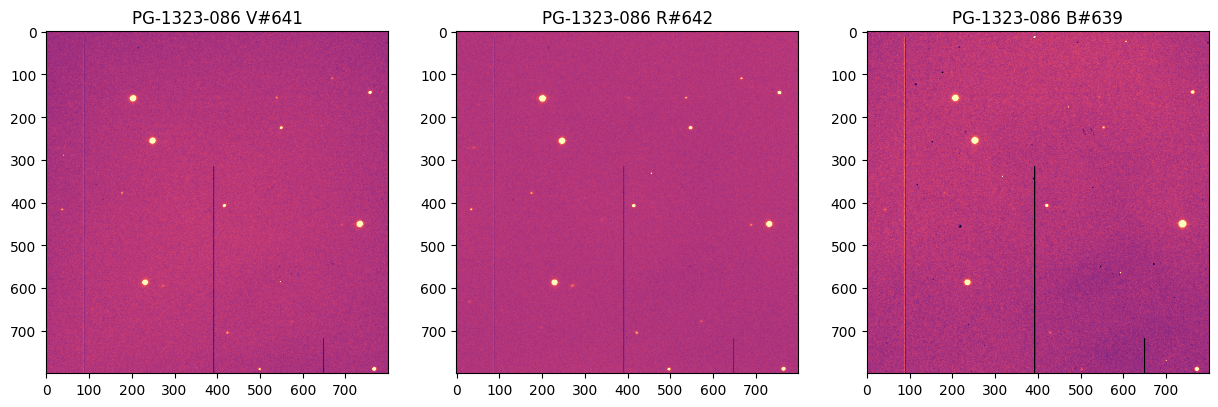

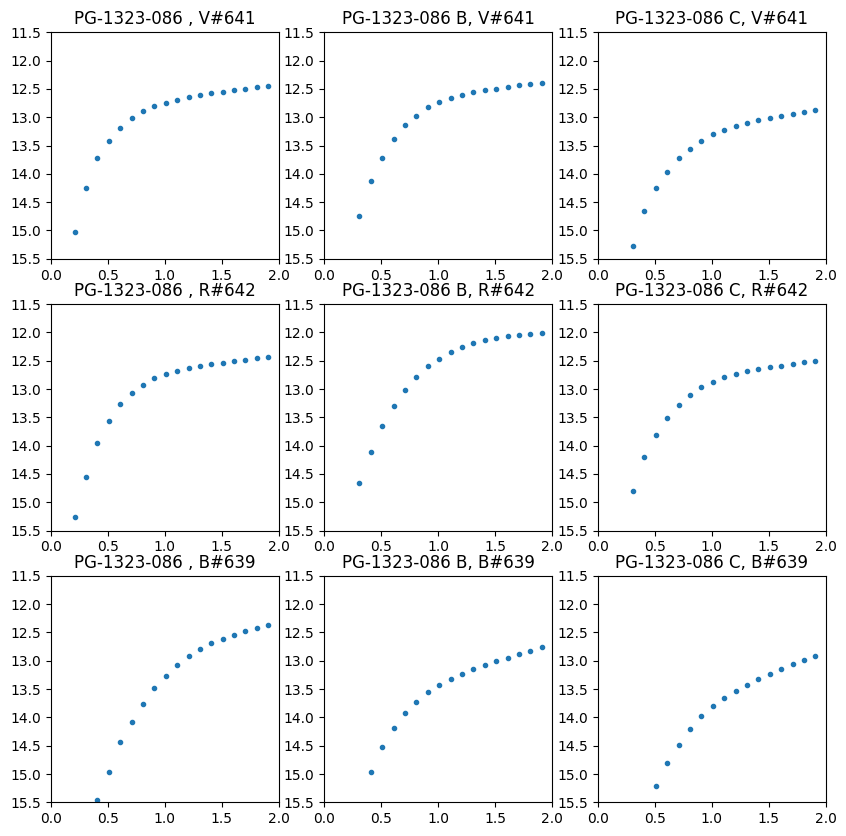

In [86]:
import astropy.io.fits as fits
import dfitspy
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from scipy import ndimage
from photutils.centroids import centroid_quadratic
from photutils.profiles import RadialProfile
from photutils.aperture import CircularAperture
import photutils.aperture as aptr
from scipy.misc import derivative

dirEx3 = '/Users/yhjo/Desktop/AstronomicalDataProcessing/Exercise/Ex3/'
dirSTD = '/Users/yhjo/Desktop/AstronomicalDataProcessing/Exercise/Ex3/STANDARD'
dirErr = '/Users/yhjo/Desktop/AstronomicalDataProcessing/Exercise/Ex3/PSError'

filters =['V#641','R#642','B#639']
fileNames = {'V#641':'EFOSC.2001-01-03T08:55:18.187.fits',
            'R#642':'EFOSC.2001-01-03T08:56:03.899.fits',
            'B#639':'EFOSC.2001-01-03T08:54:27.270.fits'}

# PG 1323-086
# PG 1323-086 B
# PG 1323-086 C
LandoltBands = ['V', 'B-V', 'U-B', 'V-R', 'R-I', 'V-I']
LandoltBand = [[13.481,	-0.140,	-0.681,	-0.048,	-0.078,	-0.127],
                [13.406,	0.761,	0.265,	0.426,	0.407,	0.833],
                [14.003,	0.707,	0.245,	0.395,	0.363,	0.759]]

# PG 1323-086		13.481	-0.140	-0.681	-0.048	-0.078	-0.127
# PG 1323-086 B		13.406	0.761	0.265	0.426	0.407	0.833
# PG 1323-086 C		14.003	0.707	0.245	0.395	0.363	0.759

#combination of 0, B, C with V, R, B
LandoltMag = np.zeros((3,3), dtype = 'f')
for i in range(len(LandoltBand)):
    LandoltMag[i][0] = LandoltBand[i][0]
    LandoltMag[i][1] = LandoltBand[i][0] - LandoltBand[i][3]
    LandoltMag[i][2] = LandoltBand[i][0] + LandoltBand[i][1]

##========================================= check the headers of the fitses of STANDARD stars
os.chdir(dirSTD)
fitsFiles = []
for fitsFile in os.listdir(dirSTD):
    fitsFiles.append(fitsFile)
keys = ['OBJECT', 'NAXIS1', 'NAXIS2', 'EXPTIME', 'HIERARCH ESO INS FILT1 NAME']
stdFiles = dfitspy.dfitsort(fitsFiles, keys)
dfitspy.dfitsort_view(stdFiles)

##========================================= get the data or the header of fits files in the directory
def getFitsData(fileName):
    fitsStdData = fits.getdata(fileName, header = False, dtype = 'f')
    stdData = fitsStdData[100:900,100:900]
    return stdData

def getFitsHeader(fileName):
    return fits.getheader(fileName)

##========================================= get var data of processed science
def getPSError(filter, type):
    previousDir = os.getcwd()
    pSError = [ [0]*800 for i in range(800) ]
    os.chdir(dirErr)
    fileName = filter+type+'.processed.error'
    if os.path.exists(fileName):
        with open(fileName, "r") as file:
            ##load data from file
            listOfLines = file.read().splitlines()   #list of strings
            for i in range(len(listOfLines)):
                line = listOfLines[i] #list of string, delimiter = ','
                listOfValues = line.split(',')
                for j in range(len(listOfValues)):
                    value = listOfValues[j]
                    if not value =='':
                        pSError[i][j] = float(value)
    os.chdir(previousDir)
    return pSError

##========================================= get RadialProfile
def getRadialProfile(coo, stdData):
    xycen = centroid_quadratic(stdData, xpeak = coo[0], ypeak = coo[1], fit_boxsize = 11, search_boxsize = 11)
    edge_radii = np.arange(25)
    rp = RadialProfile(stdData, xycen, edge_radii, mask=None)
    return rp
##========================================= get FWHM
def getFWHM(coo, stdData):
    return getRadialProfile(coo, stdData).gaussian_fwhm
##========================================= aperture factors are multiplied to the gaussian FWHM
# apertureFactor = [0.5, 0.75, 1.0, 1.5, 2.0, 2.35, 2.5, 3.0, 3.3]
# aF1 = np.arange(0.01, 2, 0.2, dtype ='f')
# aF2 = np.arange(2, 4, 0.5, dtype ='f')
# apertureFactor = np.concatenate((aF1,aF2)) 
apertureFactor = np.arange(0.01, 2, 0.1, dtype ='f')
##========================================= get magnitudes wrt the aperture factors
def getMagnitude(coo, stdData, expTime, errorData):
    magnitudes = []
    for f in apertureFactor:
        rp = getRadialProfile(coo, stdData)
        aperture = CircularAperture(coo, f * rp.gaussian_fwhm)
        phot = aptr.aperture_photometry(stdData, aperture, method = 'subpixel', error = errorData, subpixels = 5)
        mag = float(-2.5*(np.log10(phot['aperture_sum']/expTime)) + 25)
        magnitudes.append(mag)
    return magnitudes
##========================================= plotting function
def plotApertureMagnitude(coo, stdData, errorData, expTime, title, ax=None):
    if ax is None:
        ax = plt.gca()
    mag = getMagnitude(coo, stdData, expTime, errorData)
    plot = ax.plot(apertureFactor, mag, '.')
    ax.set_title(title)
    ax.set_xlim(0,2)
    ax.set_ylim(15.5,11.5)
    return plot
##========================================= choosing aperture : where the second derivative is the greates
def chooseProperAperture(coo, stdData, expTime, errorData):
    rp = getRadialProfile(coo, stdData)
    magnitude = getMagnitude(coo, stdData, expTime, errorData)
    change = []
    changeChange = []
    changeChangeRatio = []
    for i in range(len(apertureFactor)-1):
        # print(apertureFactor[i], ' : ' ,np.abs(magnitude[i+1]-magnitude[i]))
        change.append(np.abs(magnitude[i+1]-magnitude[i]))
    for i in range(len(change)-1):
        changeChange.append(np.abs(change[i+1]-change[i]))
        # print(apertureFactor[i], ' : ' ,np.abs(changeChange[i+1]-changeChange[i]))
    for i in range(len(changeChange)-1):
        changeChangeRatio.append(np.abs((changeChange[i+1]-changeChange[i])/changeChange[i]))
    # print('changeChangeRatio')
    # print(changeChangeRatio)
    # print('changeChange')
    # print(changeChange)
    maxF = max(changeChangeRatio)
    imaxF = changeChangeRatio.index(max(changeChangeRatio))
    properAperture = apertureFactor[imaxF] * rp.gaussian_fwhm
    print('factor : ', apertureFactor[imaxF])
    print('gaussianfwhm : ',rp.gaussian_fwhm)
    print()
    return properAperture
    
##========================================= extract fits data of the fitses of STANDARD stars
fig, axs = plt.subplots(1,3,figsize = (15,15))
fig_a, axs_a = plt.subplots(3,3,figsize = (10,10))
for i in range(len(os.listdir(dirSTD))):
    fitsHeader = getFitsHeader(os.listdir(dirSTD)[i])
    stdData  = getFitsData(os.listdir(dirSTD)[i])
    expTime = fitsHeader['EXPTIME']
    errorData = getPSError(filters[i],'SkyFlat')
    axs[i].imshow(stdData, vmin = np.mean(stdData) - np.std(stdData), vmax = np.mean(stdData) + np.std(stdData), cmap = 'magma')
    axs[i].set_title('PG-1323-086 '+filters[i])
    
    print('--------------------------------',filters[i],'--------------------------------')
    # PG-1323-086
    coo = np.array([733,451])
    plotApertureMagnitude(coo, stdData, errorData, expTime, 'PG-1323-086 , '+filters[i], axs_a[i][0])
    print('recom.Apeture for  : ',chooseProperAperture(coo, stdData, expTime, errorData))
    # PG-1323-086 B
    cooB = np.array([204,158])
    plotApertureMagnitude(cooB, stdData, errorData, expTime, 'PG-1323-086 B, '+filters[i], axs_a[i][1])
    print('recom.Apeture for B : ',chooseProperAperture(cooB, stdData, expTime, errorData))
    # PG-1323-086 C
    cooC = np.array([231,589])
    plotApertureMagnitude(cooC, stdData, errorData, expTime, 'PG-1323-086 C, '+filters[i], axs_a[i][2])
    print('recom.Apeture for C : ',chooseProperAperture(cooC, stdData, expTime, errorData))

# print(apertureFactor)
# print(apertures)
# plt.plot(apertureFactor, apertures)

plt.show()
            

### Ex4 Background Substraction with annulus
#### let the proper aperture 5.7 pixels(previous Ex)

In [32]:
import astropy.io.fits as fits
import dfitspy
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from scipy import ndimage
from photutils.centroids import centroid_quadratic
from photutils.profiles import RadialProfile
from photutils.aperture import CircularAperture
import photutils.aperture as aptr

dirEx3 = '/Users/yhjo/Desktop/AstronomicalDataProcessing/Exercise/Ex3/'
dirSTD = '/Users/yhjo/Desktop/AstronomicalDataProcessing/Exercise/Ex3/STANDARD'
dirErr = '/Users/yhjo/Desktop/AstronomicalDataProcessing/Exercise/Ex3/PSError'

filters =['V#641','R#642','B#639']
fileNames = {'V#641':'EFOSC.2001-01-03T08:55:18.187.fits',
            'R#642':'EFOSC.2001-01-03T08:56:03.899.fits',
            'B#639':'EFOSC.2001-01-03T08:54:27.270.fits'}

os.chdir(dirSTD)
fitsFiles = []
for fitsFile in os.listdir(dirSTD):
    fitsFiles.append(fitsFile)
keys = ['OBJECT', 'EXPTIME', 'HIERARCH ESO INS FILT1 NAME']
stdFiles = dfitspy.dfitsort(fitsFiles, keys)
dfitspy.dfitsort_view(stdFiles)
##========================================= get data of fits files in the directory
def getFitsData(fileName):
    fitsStdData = fits.getdata(fileName, header = False, dtype = 'f')
    stdData = fitsStdData[100:900,100:900]
    return stdData

def getFitsHeader(fileName):
    return fits.getheader(fileName)

data = getFitsData('EFOSC.2001-01-03T08:55:18.187.fits')


phot = aperture_photometry(data, aperture, method='subpixel',error=errorimage, subpixels=5)
# annulus_apertures = CircularAnnulus(standard_coo, r_in=r_in, r_out=r_out)
# annulus_masks = annulus_apertures.to_mask(method='center')
# annulus_data = annulus_masks.multiply(DATA)
# annulus_data_1d = annulus_data[annulus_masks.data > 0]


             filename             	EXPTIME	HIERARCH ESO INS FILT1 NAME	       OBJECT       
----------------------------------	-------	---------------------------	--------------------
EFOSC.2001-01-03T08:55:18.187.fits	4.9968 	           V#641           	PG-1323-086-phot-std
EFOSC.2001-01-03T08:56:03.899.fits	4.9969 	           R#642           	PG-1323-086-phot-std
EFOSC.2001-01-03T08:54:27.270.fits	9.9968 	           B#639           	PG-1323-086-phot-std


In [21]:
import os
print(os.getcwd())
# os.chdir()
print(os.getcwd())

/Users/yhjo/Desktop/AstronomicalDataProcessing/Exercise/Ex3/STANDARD
/Users/yhjo/Desktop/AstronomicalDataProcessing/Exercise/Ex3/STANDARD
